In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals, generators

import os
import pathlib
import functools
import numpy as np
import tensorflow as tf
from tensorflow import keras
keras.__version__
import pandas as pd
import matplotlib.pyplot as plt
from os import path
from tensorflow.keras import layers
import ffmpeg
import IPython.display as ipd

from pydub import AudioSegment


In [7]:
tf.debugging.set_log_device_placement(True)

strategy = tf.distribute.OneDeviceStrategy (device="/GPU:3")
num_gpus = strategy.num_replicas_in_sync

print('Number of GPUs: {}'.format(num_gpus))
# Place tensors on the CPU
with strategy.scope():
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

c = tf.matmul(a, b)
print(c)

Number of GPUs: 1
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [26]:
from __future__ import generators
# http://signalsprocessed.blogspot.com/2016/08/audio-resampling-in-python.html

data_location = "../fma_small/"

# how many samples to generate
sample_length = 20000

# Batch size
batch_size = 64

# Start with shaping data by dividing by 30000.
# https://stackoverflow.com/questions/10377998/how-can-i-iterate-over-files-in-a-given-directory

# Define a generator to produce the real music data. Distinct from model generator
def music_generator(bs=batch_size):
    exp_array = np.zeros((bs,sample_length))
    i = 0
    for subdir, dirs, files in os.walk(data_location):
          for file in files:
              #print os.path.join(subdir, file)
              filepath = subdir + os.sep + file
              # Decodes audio
              if filepath.endswith(".mp3"):
                    mp3_audio = AudioSegment.from_file(filepath, format="mp3")
                    audio_array = mp3_audio.get_array_of_samples()[:3*sample_length:3]
                    exp_array[i] = audio_array
#                     print('.')
                    i+=1
                    if (i >= bs):
                        # Convert to tensor
#                         data=tf.convert_to_tensor(exp_array)
                        out= exp_array/30000
                        out = tf.reshape(out,[bs,sample_length,1])
                        i = 0
                        #  yield (out, out)
                        print("yielding " + str(bs) +" samples...")
                        yield out
# Initializes our generator
get_song = music_generator()

def music_generator2():
    for subdir, dirs, files in os.walk(data_location):
          for file in files:
              #print os.path.join(subdir, file)
              filepath = subdir + os.sep + file
              # Decodes audio
              if filepath.endswith(".mp3"):
                mp3_audio = AudioSegment.from_file(filepath, format="mp3")
                audio_array = mp3_audio.get_array_of_samples()[:10*sample_length:10]
                out= audio_array
#                 out = tf.reshape(out,[1,sample_length,1])
                print("yielding samples...")
                yield out
# Initializes our generator
get_song = music_generator2()

yielding samples...


AttributeError: 'array.array' object has no attribute 'shape'

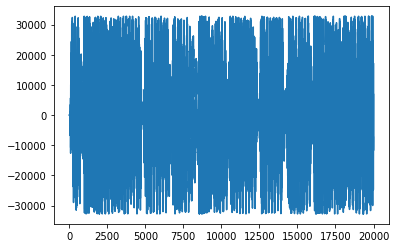

In [27]:
song = next(get_song)
plt.plot(song)
plt.show
# song
song.shape

In [2]:
def saveAudio(arr, path):
    saved = tf.audio.encode_wav(tf.cast(arr, float) ,22000)
    tf.io.write_file(path, saved, name=None)

<tf.Tensor: shape=(200000, 1), dtype=float32, numpy=
array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.36943334],
       [0.14523333],
       [0.20986667]], dtype=float32)>

In [61]:
saveAudio(song*30000, 'results/exp.wav')

In [28]:
ipd.Audio(song, rate=4400)

In [12]:
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.OneDeviceStrategy (device="GPU:3")
num_gpus = strategy.num_replicas_in_sync

print('Number of GPUs: {}'.format(num_gpus))

Number of GPUs: 1


In [41]:
# Define the generator for the music
with strategy.scope():
    generator_input = keras.Input(shape=(sample_length,1))
    # https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e
    x = layers.LSTM(100, return_sequences=True)(generator_input)
    # x = layers.LSTM(500, return_sequences=True)(x)
    x = layers.LSTM(250, return_sequences=True)(x)
    x = layers.LSTM(100, return_sequences=True)(x)
    x = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(x)


    generator = keras.models.Model(generator_input,x)
    generator.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 5000, 1)]         0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 5000, 100)         40800     
_________________________________________________________________
lstm_11 (LSTM)               (None, 5000, 250)         351000    
_________________________________________________________________
lstm_12 (LSTM)               (None, 5000, 100)         140400    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5000, 1)           101       
Total params: 532,301
Trainable params: 532,301
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Define the discriminator
# Chollet,307
with strategy.scope():
    discriminator_input = layers.Input(shape=(sample_length, 1))

    x = layers.LSTM(250)(discriminator_input)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    discriminator = keras.models.Model(discriminator_input,x)
    discriminator.summary()

    discriminator_optimizer = keras.optimizers.RMSprop(
        lr=0.0008,
        clipvalue=1.0,
        decay = 1e-8)

    discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 5000, 1)]         0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 250)               252000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 251       
Total params: 252,251
Trainable params: 252,251
Non-trainable params: 0
_________________________________________________________________


In [46]:
with strategy.scope(): 
    discriminator.trainable = False

    gan_input = keras.Input(shape=(sample_length, 1))
    gan_output = discriminator(generator(gan_input))

    gan = keras.models.Model(gan_input, gan_output)

    gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0,decay=1e-8)
    gan.compile(optimizer=gan_optimizer,loss='binary_crossentropy')


Define strategy and use it to train model

In [48]:

iterations = 10
batch_size = 20
save_dir = 'results'


start = 0
with strategy.scope():
    real_data = music_generator(bs=batch_size)
    for step in range(iterations):
        random_vectors = np.random.normal(size=(batch_size, sample_length, 1))

        generated_music = generator.predict(random_vectors)

        stop = start + batch_size
        real_music = next(real_data)

        combined_music = np.concatenate([generated_music, real_music])

        labels = np.concatenate([np.ones((batch_size,1)),np.zeros((batch_size,1))])
        labels += 0.05 * np.random.random(labels.shape)

        print(combined_music.shape)
        print(labels.shape)
        
        discriminator.trainable = True
        
#       train_on_batch doesn't seem to run well on one-device strategy. OR at all, in fact.  

        d_loss = discriminator.train_on_batch(combined_music, labels)
        
        discriminator.trainable = False

        random_latent_vectors = np.zeros((batch_size, 1))

        misleading_targets = np.zeros((batch_size, 1))

        a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

        start += batch_size
        if start > 10000 - batch_size:
            start = 0

        if step % 100 == 0:
            gan.save_weights('gan.h5')

            print('discrimator loss: ', d_loss)
            print('advsersarial loss: ', a_loss)

            ipd.Audio(generated_music[0]*30000, rate=22000)
            saveAudio(song*30000, 'results/latest' + start + '.wav')

                

yielding 20 samples...
(40, 5000, 1)
(40, 1)


TypeError: 'NoneType' object is not callable

In [27]:
from keras.layers import LSTM, RepeatVector, TimeDistributed


latent_dim = 4

# https://machinelearningmastery.com/lstm-autoencoders/
autoencoder_input = layers.Input(shape=(sample_length, 1))
x = layers.LSTM(128,  return_sequences=True)(autoencoder_input)
x = layers.LSTM(64,  return_sequences=False)(x) 
encoded = layers.Dense(latent_dim, activation='sigmoid')(x)
to_decode = layers.RepeatVector(sample_length)(encoded)
x = layers.LSTM(64,  return_sequences=True)(to_decode)
x = layers.LSTM(128,  return_sequences=True)(x)
x = layers.LSTM(64,  return_sequences=True)(x)
x = layers.LSTM(32,  return_sequences=True)(x)
x = layers.LSTM(1, return_sequences=True)(x)



autoencoder = keras.models.Model(autoencoder_input,x)
autoencoder.compile(optimizer =, loss='mae')
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 200000, 1)]       0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 200000, 128)       66560     
_________________________________________________________________
lstm_21 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 260       
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 200000, 4)         0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 200000, 64)        17664     
_________________________________________________________________
lstm_23 (LSTM)               (None, 200000, 128)       9881

In [ ]:
with strategy.scope():
  autoencoder.fit_generator(
  music_generator,
  steps_per_epoch=20,
  epochs=1000,
  )

Attempts to create a standard generative network, non-adversarial, simple regression model.

https://medium.com/intel-student-ambassadors/music-generation-using-lstms-in-keras-9ded32835a8f


Potentially coudl use this for more preprocessing:

https://github.com/unnati-xyz/music-generation/blob/master/Blog_Post_Music_Gen_1.md

In [116]:
from sklearn.preprocessing import normalize, MinMaxScaler

def train_sequence_generator(lookback = 25, bs = 200):
    data_location = "../data/train"
    data_array = np.zeros((bs,lookback))
    label_array = np.zeros((bs, 1))
    counter = 0
    for subdir, dirs, files in os.walk(data_location):
          for file in files:
              #print os.path.join(subdir, file)
              filepath = subdir + os.sep + file
              # Decodes audio
              if filepath.endswith(".mp3"):
                    mp3_audio = AudioSegment.from_file(filepath, format="mp3")
                    # rudimentary downsample factor of 3
                    audio_array = mp3_audio.get_array_of_samples()
                    audio_array = np.array(audio_array)
                    audio_array = audio_array.astype('float32')
                    l = len(audio_array)
                    audio_array = audio_array.reshape((l,1))
                    scaler = MinMaxScaler(feature_range=(-1,1))
                    scaler.fit(audio_array)
                    audio_array = scaler.transform(audio_array)
                    audio_array = audio_array.reshape((1,l))
                    audio_array = audio_array[0]
                    audio_array = np.nan_to_num(audio_array, nan=0.0)
                    if not np.isnan(audio_array).any():
                        if not np.isinf(audio_array).any() :
#                         https://kite.com/python/answers/how-to-check-for-nan-elements-in-a-numpy-array-in-python
                            for i in range (0,len(audio_array) - lookback - 1,100):
                                data = audio_array[i:i+lookback]
        #                         data = data.reshape((1,lookback,1))
                                label = audio_array[i+lookback+1:i+lookback+2]
                                label.reshape((1,1))
                                data_array[counter] = data
                                label_array[counter] = label
                                counter +=1
                                if(counter == bs):
                                    counter = 0
                                    out_data = data_array.reshape(bs,lookback,1)
                                    out_labels = label_array.reshape(bs,1)
                                    yield (out_data,out_labels)
                        else:
                            print("inf found!")
                    else:
                        print("nan found!")
                        
def test_sequence_generator(lookback = 25, bs = 200):
    data_location = "../data/test"
    data_array = np.zeros((bs,lookback))
    label_array = np.zeros((bs, 1))
    counter = 0
    for subdir, dirs, files in os.walk(data_location):
          for file in files:
              #print os.path.join(subdir, file)
              filepath = subdir + os.sep + file
              # Decodes audio
              if filepath.endswith(".mp3"):
                    mp3_audio = AudioSegment.from_file(filepath, format="mp3")
                    # rudimentary downsample factor of 3
                    audio_array = mp3_audio.get_array_of_samples()
                    audio_array = np.array(audio_array)
                    audio_array = audio_array.astype('float32')
#                     audio_array = audio_array/30000
                    for i in range (0,len(audio_array) - lookback - 1,100):
                        data = audio_array[i:i+lookback]
#                         data = data.reshape((1,lookback,1))
                        label = audio_array[i+lookback+1:i+lookback+2]
                        label.reshape((1,1))
                        data_array[counter] = data
                        label_array[counter] = label
                        counter +=1
                        if(counter == bs):
                            counter = 0
                            out_data = data_array.reshape(bs,lookback,1)
                            out_labels = label_array.reshape(bs,1)
                            yield (out_data,out_labels)
                        
train_gen = train_sequence_generator(bs = 20000)
test_gen = test_sequence_generator()

# https://github.com/keras-team/keras/issues/2134
                                              

In [117]:
x,y = next(train_gen)
x.shape
y.shape
print (x)

 Data MaX:  32767.0
 Data min:  -32768.0
 Data MaX:  1.0
 Data min:  -1.0
 Data mean:  0.0009519441030044109
 Data var:  0.06031372567691296
[[[ 1.52587891e-05]
  [ 1.52587891e-05]
  [ 1.52587891e-05]
  ...
  [ 1.52587891e-05]
  [ 1.52587891e-05]
  [ 1.52587891e-05]]

 [[ 1.52587891e-05]
  [ 1.52587891e-05]
  [ 1.52587891e-05]
  ...
  [ 1.52587891e-05]
  [ 1.52587891e-05]
  [ 1.52587891e-05]]

 [[ 1.52587891e-05]
  [ 1.52587891e-05]
  [ 1.52587891e-05]
  ...
  [ 1.52587891e-05]
  [ 1.52587891e-05]
  [ 1.52587891e-05]]

 ...

 [[ 2.73914695e-01]
  [ 2.61799037e-01]
  [ 2.27161065e-01]
  ...
  [ 2.26092935e-01]
  [ 1.82818338e-01]
  [ 3.56191337e-01]]

 [[ 1.81536585e-01]
  [ 1.23430230e-01]
  [ 1.73113599e-01]
  ...
  [-1.07743956e-01]
  [-9.68490094e-02]
  [-1.65117875e-01]]

 [[ 4.20080870e-02]
  [ 7.89654404e-02]
  [ 5.24757765e-02]
  ...
  [ 3.03669780e-01]
  [ 2.02624545e-01]
  [ 2.81208515e-01]]]


In [11]:
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping, History
fp = 'models/bestrnnmodel.h5'
mc_cp = ModelCheckpoint(filepath = fp, save_best_only = True, verbose = 1)
    
es_cb = EarlyStopping(monitor = 'val_loss', mode='min', verbose = 1, patience = 5, min_delta=0.0001, restore_best_weights=True)
cb_list = [mc_cp]

In [5]:
from keras.layers import Dense, LSTM, LeakyReLU
from keras.models import Sequential, load_model
# with strategy.scope():
regression_model = Sequential()
regression_model.add(LSTM(100, activation='linear', input_shape=(None, 1)))
regression_model.add(LeakyReLU())
regression_model.add(Dense(50, activation='linear'))
regression_model.add(LeakyReLU())
regression_model.add(Dense(25, activation='linear'))
regression_model.add(LeakyReLU())
regression_model.add(Dense(12, activation='linear'))
regression_model.add(LeakyReLU())
regression_model.add(Dense(units=1, activation='linear'))
regression_model.add(LeakyReLU())


regression_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
regression_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)               

In [7]:
from keras.layers import Conv1D, MaxPooling1D, Dropout

regression_model2 = Sequential()
regression_model2.add(Conv1D(32, 5, activation='linear', input_shape=(None, 1)))
regression_model2.add(LeakyReLU())
regression_model2.add(MaxPooling1D(3))
regression_model2.add(Conv1D(32, 5, activation='linear'))
regression_model2.add(LeakyReLU())
regression_model2.add(LSTM(500, activation='linear', recurrent_dropout=0.3))
regression_model2.add(LeakyReLU())
regression_model2.add(Dense(250, activation='linear'))
regression_model2.add(Dropout(0.5))
regression_model2.add(LeakyReLU())
regression_model2.add(Dense(25, activation='linear'))
regression_model2.add(LeakyReLU())
regression_model2.add(Dense(12, activation='linear'))
regression_model2.add(LeakyReLU())
regression_model2.add(Dense(units=1, activation='linear'))
regression_model2.add(LeakyReLU())


regression_model2.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
regression_model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, None, 32)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, None, 32)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 500)               1066000   
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 500)              

In [ ]:
# with strategy.scope():
lb = 2000
batchsize = 50

train_gen = train_sequence_generator(lookback = lb, bs = batchsize)
test_gen = test_sequence_generator(lookback = lb, bs = batchsize)
history = regression_model2.fit_generator(train_gen, 
                                         steps_per_epoch = 100,
                                         epochs = 100,
                                         validation_data=test_gen,
                                         validation_steps = 5,
                                         callbacks = cb_list)

# https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object
with open('/regression2history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

regression_model2.save('models/regression_model2.hd5')
        
gendata, res = next(test_gen)

newsong = song_generator(200, regression_model, gendata[20])
saveAudio(newsong.reshape(20000,1)*30000, 'results/regressionmodel3output.wav')

Epoch 1/100
 64/100 [==================>...........] - ETA: 3:08 - loss: 0.0287 - mean_squared_error: 0.0349

In [6]:
# with strategy.scope():
lb = 200
batchsize = 3000

train_gen = train_sequence_generator(lookback = lb, bs = batchsize)
test_gen = test_sequence_generator(lookback = lb, bs = batchsize)
history = regression_model.fit_generator(train_gen, steps_per_epoch = 5, epochs = 25,validation_data=test_gen, validation_steps = 20, callbacks = cb_list)

Epoch 1/25
5/5 [==============================] - 17s 3s/step - loss: 0.0737 - mean_squared_error: 0.0570 - val_loss: 0.1607 - val_mean_squared_error: 0.0553

Epoch 00001: val_loss improved from inf to 0.16074, saving model to models/bestrnnmodel.h5
Epoch 2/25
5/5 [==============================] - 9s 2s/step - loss: 0.1207 - mean_squared_error: 0.0567 - val_loss: 0.0124 - val_mean_squared_error: 0.0520

Epoch 00002: val_loss improved from 0.16074 to 0.01243, saving model to models/bestrnnmodel.h5
Epoch 3/25
5/5 [==============================] - 7s 1s/step - loss: 8086477022324327.0000 - mean_squared_error: 233387549786112.0000 - val_loss: 0.0171 - val_mean_squared_error: 1125638910269980672.0000

Epoch 00003: val_loss did not improve from 0.01243
Epoch 4/25
5/5 [==============================] - 10s 2s/step - loss: 11762334016785614.0000 - mean_squared_error: 4220128487299612672.0000 - val_loss: 0.0606 - val_mean_squared_error: 2961985386774230204416.0000

Epoch 00004: val_loss did n

In [22]:
def song_generator(lookback,model, starter,len = 20000):
    newsong = np.zeros(len+lookback)
    for i in range(lookback):
        newsong[i] = starter[i]
    print("copied song...")
    for i in range(len-lookback-1):
        newsong[lookback+i] = model.predict(newsong[lookback+i:i+2*lookback].reshape(1,lookback,1))
        if i%100==0:
            print("Predicted " + str(i)+ " samples")
    return newsong[lookback:]
    

In [10]:
gendata, res = next(test_gen)

In [23]:
# Predicting takes a while!
newsong = song_generator(200, regression_model, gendata[20])

copied song...
Predicted 0 samples
Predicted 100 samples
Predicted 200 samples
Predicted 300 samples
Predicted 400 samples
Predicted 500 samples
Predicted 600 samples
Predicted 700 samples
Predicted 800 samples
Predicted 900 samples
Predicted 1000 samples
Predicted 1100 samples
Predicted 1200 samples
Predicted 1300 samples
Predicted 1400 samples
Predicted 1500 samples
Predicted 1600 samples
Predicted 1700 samples
Predicted 1800 samples
Predicted 1900 samples
Predicted 2000 samples
Predicted 2100 samples
Predicted 2200 samples
Predicted 2300 samples
Predicted 2400 samples
Predicted 2500 samples
Predicted 2600 samples
Predicted 2700 samples
Predicted 2800 samples
Predicted 2900 samples
Predicted 3000 samples
Predicted 3100 samples
Predicted 3200 samples
Predicted 3300 samples
Predicted 3400 samples
Predicted 3500 samples
Predicted 3600 samples
Predicted 3700 samples
Predicted 3800 samples
Predicted 3900 samples
Predicted 4000 samples
Predicted 4100 samples
Predicted 4200 samples
Predicte

In [25]:
ipd.Audio(newsong*30000, rate=10000)

In [30]:
saveAudio(newsong.reshape(20000,1)*30000, 'results/basic.wav')
regression_model.save('models/regression1.hd5')

In [120]:
ipd.Audio('results/basic.wav')